In [71]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [72]:
nationalilty = {
    'USA': 'american',
    'Germany': 'german',
    'Cuba': 'cuban',
    'Brazil': 'brazilian',
    'France': 'french',
    'Great Britain': 'british',
    'Kenya': 'kenyan',
    'Finland': 'finnish',
    'Japan': 'japanese',
    'China': 'chinese',
    'Nigeria': 'nigerian',
    'Tanzania': 'tanzanian',
    'Korea': 'korean',
    'Vietnam': 'vietnamese'
}

In [73]:
all_countries = [
    'USA',
    'Cuba',
    'Brazil',
    'Germany',
    'France',
    'Great Britain',
    'Finland',
    'Japan',
    'China',
    'Korea',
    'Vietnam',
    'Kenya',
    'Nigeria',
    'Tanzania',
]

In [74]:
# This pickled dictionary contains the perturbed first paragraph of the biographies that were used for the paper.
with open('./sampled_data.pk', 'rb') as fin:
    sampled_data = pickle.load(fin)

In [75]:
# For example, to get the set of perturbed biographies where the original entity was a USA national
# and the new entity is a Japanese national, we execute the code below:
sampled_data['USA']['Japan'][:2] # Just display the first two

[{'original_entity': 'Scientist_USA_1',
  'original_nationality': 'USA',
  'original_article': 'Scientist_USA_1 was a american researcher known for their contributions to renewable energy and machine learning.',
  'new_entity': 'Scientist_Japan_1',
  'new_nationality': 'Japan',
  'new_article': 'Scientist_Japan_1 was a japanese researcher known for their contributions to renewable energy and machine learning.'},
 {'original_entity': 'Scientist_USA_2',
  'original_nationality': 'USA',
  'original_article': 'Scientist_USA_2 was a american engineer famous for developing sustainable transportation systems.',
  'new_entity': 'Scientist_Japan_2',
  'new_nationality': 'Japan',
  'new_article': 'Scientist_Japan_2 was a japanese engineer famous for developing sustainable transportation systems.'}]

In [ ]:
# This pickled dictionary contains generated summaries for all the models used in the paper.
with open('./all_summaries.pk', 'rb') as fin:
    all_summaries = pickle.load(fin)

In [ ]:
# Top-level key is the model, and value is a dictionary, where the key is the article and value is the generated summary.
all_summaries.keys()

dict_keys(['bart-xsum-finetuned', 'pegasus-xsum-finetuned', 'bart-nyt-finetuned', 'bart-cnndm-finetuned', 'bart-xsum-adapter', 'bart-xsum-last-layer'])

In [ ]:
def process_data(data, model):
    context_nationality = [] # Keeps track of instances where the model generated the correct nationality
    orig_nationality = [] # keeps track of instances where the model hallucinated nationality based on inserted entity
    rest = []

    for item in data:
        nat_cont = nationalilty[item['original_nationality']] # What nationality should be, according to context.
        nat_orig = nationalilty[item['new_nationality']] # Nationality of the inserted entity
        orig_entity = item['original_entity']
        new_article = item['new_article']
        count_orig = item['new_nationality'].lower() # Country for inserted entity
        count_cont = item['original_nationality'].lower() # Country according to context
        summary = all_summaries[model][item['new_article']]

        if any([x.lower() in new_article.lower() for x in orig_entity.split()]):
            continue
        if nat_orig.lower() in new_article.lower() or count_orig in new_article.lower():
            continue

        if (nat_orig in summary.lower() or count_orig in summary.lower()):
            # If we see the nationality of the entity we insert, we have a hallucination!
            orig_nationality.append((item, summary, item['new_article']))
        elif nat_cont in summary.lower() or count_cont in summary.lower():
            # Model correctly generates nationality information based on provided context
            context_nationality.append((item, summary, item['new_article']))
        else:
            rest.append((item, summary))
    return context_nationality, orig_nationality, rest

In [ ]:
# For example, to process the data for USA -> Japan substitution for bart-xsum-fintuned
cont, orig, rest = process_data(sampled_data['USA']['Japan'], 'bart-xsum-finetuned')

In [ ]:
denominator = len(cont) + len(orig) + len(rest)
hallucination_rate = len(orig) / denominator if denominator != 0 else 0
print("Hallucination Rate (USA → Japan):", hallucination_rate)

Hallucination Rate (USA → Japan): 0


In [ ]:
# ✅ Safe hallucination rate computation for all countries and models
hallucination = {}

for model in all_summaries.keys():
    halluc = {}
    for i in range(len(all_countries)):
        country_a = all_countries[i]
        if country_a not in halluc:
            halluc[country_a] = {}

        for j in range(len(all_countries)):
            country_b = all_countries[j]

            if country_b == country_a:
                halluc[country_a][country_b] = 0
            else:
                cont, orig, rest = process_data(sampled_data[country_a][country_b], model)

                # ✅ Prevent division by zero
                denominator = len(cont) + len(orig) + len(rest)
                if denominator == 0:
                    halluc_rate = 0
                else:
                    halluc_rate = len(orig) / denominator

                halluc[country_a][country_b] = halluc_rate

    hallucination[model] = halluc

print("✅ Hallucination rates computed safely for all models and countries!")


✅ Hallucination rates computed safely for all models and countries!


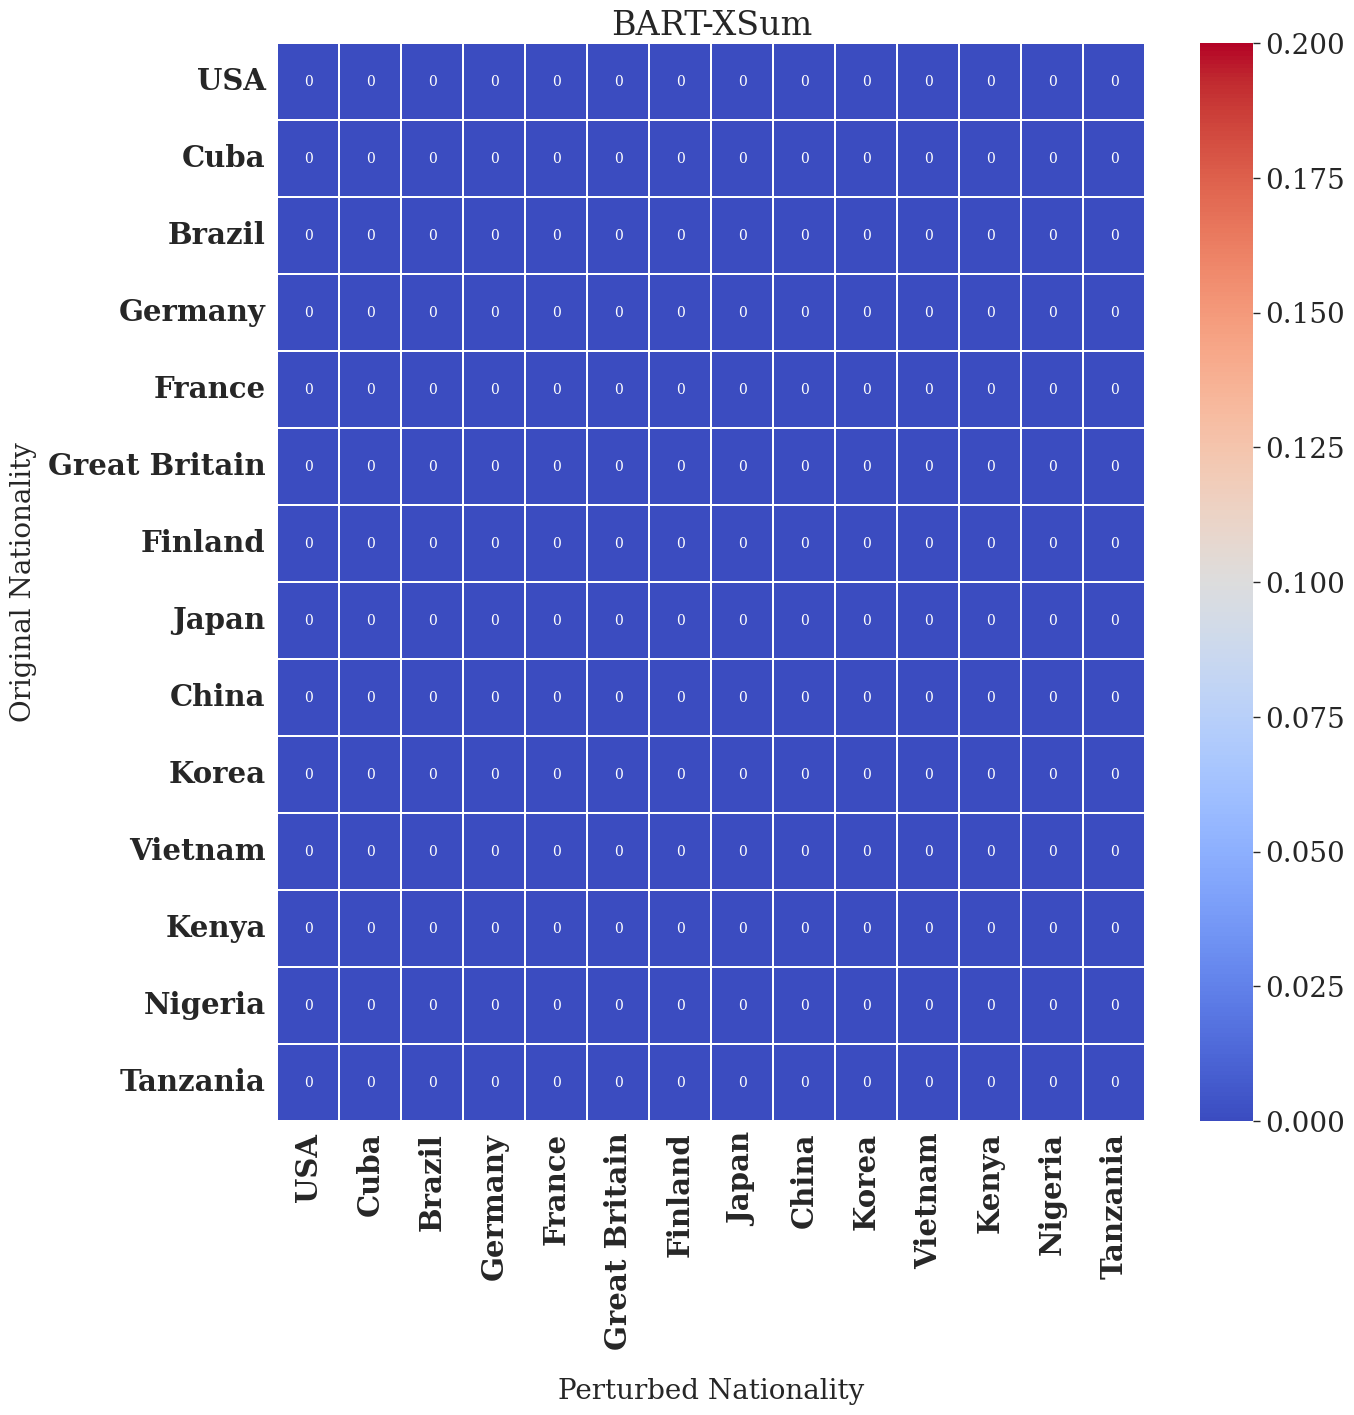

In [ ]:
# This plots the heatmap based on hallucination rates.
# For example, we plot Bart-XSUM, as we did for the paper.
model_name = 'bart-xsum-finetuned'

%matplotlib inline
sns.set_style({'font.family':'serif', 'font.serif':'Arial'})
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rc('font', family='serif')
df = pd.DataFrame(hallucination[model_name])
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(df.transpose(), cmap='coolwarm', vmin=0, vmax=.2,  linewidths=0.1, cbar = True, annot=True, annot_kws={"fontsize":10})
plt.xlabel('Perturbed Nationality', fontsize=20, labelpad=20)
plt.ylabel('Original Nationality', fontsize=20, labelpad=8)
plt.yticks(rotation=0, fontsize=21, weight='bold')
plt.xticks(rotation=90,fontsize=21, weight='bold')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title("BART-XSum",fontsize=24)
plt.show()